In [2]:
import h5py
import os
import argparse
import glob
import numpy as np
import os 
from tqdm import tqdm
import matplotlib.pyplot as plt
from tabulate import tabulate
import json
import glob

In [26]:
PRED_PATH=r'../repos/latent-diffusion/models/ldm/v4_ppg2abp-kl-f4/samples/00077424/2024-10-15-13-06-52/numpy'
# PRED_PATH=r'../repos/latent-diffusion/models/ldm/v3_ppg2abp-kl-f4\samples\00722624\2024-10-09-16-01-57/numpy'

In [27]:
out = []
gt = []
files = glob.glob(PRED_PATH+"/*.npz")
for file in files:
    a = np.load(file)
    _out = a['arr_0'].squeeze()
    _gt = a['arr_1'].squeeze()
    out.append(_out)
    gt.append(_gt)
out = np.concatenate(out)
gt = np.concatenate(gt)

In [19]:
out.shape

(9984, 256)

110

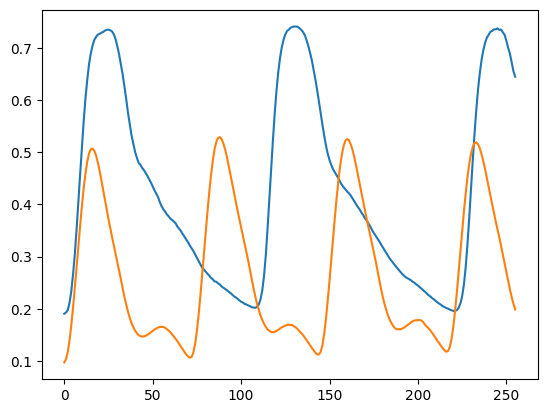

In [28]:
i = np.random.randint(128)
plt.plot(out[i])
plt.plot(gt[i])
i

In [21]:

def calc_min_max(x):
    # x = (x.astype(np.float32)/127.5-1)
    return np.nanmin(x,axis=1),np.nanmax(x,axis=1)

In [29]:
scales = np.load(r"../data\processed\BP_npy\0625_256_2_clean\p00\scale_train.npy")

In [30]:
gt[:] -= scales[0,0]
gt[:] /= scales[0,1]
out[:] -= scales[0,0]
out[:] /= scales[0,1]

In [24]:
gt_min,gt_max = calc_min_max(gt)
out_min,out_max = calc_min_max(out)
errors = np.zeros((2,*out_min.shape))
errors[0,:]=gt_min-out_min
errors[1,:]=gt_max-out_max
gt_mean = np.mean(gt.flatten())
out_mean = np.mean(out.flatten())
gt_std = np.std(gt.mean(axis=1),dtype=np.float64)
out_std = np.std(out.mean(axis=1),dtype=np.float64)
n_samples = errors.shape[1]
me = np.mean(errors,axis=1)
mae = np.mean(np.abs(errors),axis=1)
rmse = np.sqrt(np.mean(errors**2,axis=1))
std = np.std(errors,axis=1)
print(me.shape,mae.shape,rmse.shape,std.shape)
error_5 = np.count_nonzero(np.abs(errors)<=5,axis=1)/n_samples*100
error_15 = np.count_nonzero(np.abs(errors)<=15,axis=1)/n_samples*100
error_10 = np.count_nonzero(np.abs(errors)<=10,axis=1)/n_samples*100

(2,) (2,) (2,) (2,)


In [25]:
print("""
          test data samples:
          # samples : {}
          
          Eval Stats:   DBP    SBP
          MAE:        {:6.3f} {:6.3f}
          RMSE:       {:6.3f} {:6.3f}
          Mean Error: {:6.3f} {:6.3f}
          STD:        {:6.3f} {:6.3f}
          
          BHS standards range:
          Error   <5mmHg <10mmHg <15mmHg
          gradeA     60%     85%     95%
          gradeB     50%     75%     90%
          gradeC     40%     65%     85%
          DBP     {:5.1f}%  {:5.1f}%  {:5.1f}%
          SBP     {:5.1f}%  {:5.1f}%  {:5.1f}%
           
          
          """.format(
            n_samples,
            *mae,
            *rmse,
            *me,
            *std,
            error_5[0], error_10[0], error_15[0],
            error_5[1], error_10[1], error_15[1],
          ))


          test data samples:
          # samples : 9984
          
          Eval Stats:   DBP    SBP
          MAE:        10.372 21.872
          RMSE:       13.778 27.683
          Mean Error: -6.700 -14.099
          STD:        12.039 23.823
          
          BHS standards range:
          Error   <5mmHg <10mmHg <15mmHg
          gradeA     60%     85%     95%
          gradeB     50%     75%     90%
          gradeC     40%     65%     85%
          DBP      34.5%   59.7%   76.1%
          SBP      16.0%   30.1%   42.8%
           
          
          
